# Levelset Segmentation <a href="https://mybinder.org/v2/gh/InsightSoftwareConsortium/SimpleITK-Notebooks/master?filepath=Python%2F31_Levelset_Segmentation.ipynb"><img style="float: right;" src="https://mybinder.org/badge_logo.svg"></a>


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import SimpleITK as sitk
from myshow import myshow, myshow3d

# Download data to work on
%run update_path_to_download_script
from downloaddata import fetch_data as fdata

In [2]:
img_T1 = sitk.ReadImage(fdata("nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT1.nrrd"))
img_T2 = sitk.ReadImage(fdata("nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT2.nrrd"))
img_T1_255 = sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8)
img_T1_255 = sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8)

Fetching nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT1.nrrd
Fetching nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT2.nrrd


In [3]:
hello_world = 42 ### original line was sITK.Show(img_T1, title="T1")

In [4]:
idx = (106, 116, 141)
pt = img_T1.TransformIndexToPhysicalPoint(idx)

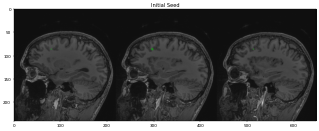

In [5]:
seg = sitk.Image(img_T1.GetSize(), sitk.sitkUInt8)
seg.CopyInformation(img_T1)
seg[idx] = 1
seg = sitk.BinaryDilate(seg, [3] * 3)
myshow3d(
    sitk.LabelOverlay(img_T1_255, seg),
    zslices=range(idx[2] - 3, idx[2] + 4, 3),
    dpi=30,
    title="Initial Seed",
)

In [6]:
stats = sitk.LabelStatisticsImageFilter()
stats.Execute(img_T1, seg)
print(stats)

itk::simple::LabelStatisticsImageFilter
  UseHistograms: 1
  Labels: [ 1, 0 ]
  Debug: 0
  NumberOfThreads: 8
  NumberOfWorkUnits: 0
  Commands: (none)
  ProgressMeasurement: 0
  ActiveProcess:
    LabelStatisticsImageFilter (0x7ff3013070b0)
      RTTI typeinfo:   itk::LabelStatisticsImageFilter<itk::Image<float, 3u>, itk::Image<unsigned char, 3u> >
      Reference Count: 1
      Modified Time: 2422
      Debug: Off
      Object Name: 
      Observers: 
        DeleteEvent(FunctionCommand)
      Inputs: 
        LabelInput: (0x7ff3042297e0) *
        Primary: (0x7ff3013090f0) *
      Indexed Inputs: 
        0: Primary (0x7ff3013090f0)
      Required Input Names: LabelInput, Primary
      NumberOfRequiredInputs: 1
      Outputs: 
        Primary: (0x0)
      Indexed Outputs: 
        0: Primary (0x0)
      NumberOfRequiredOutputs: 0
      Number Of Work Units: 8
      ReleaseDataFlag: Off
      ReleaseDataBeforeUpdateFlag: On
      AbortGenerateData: Off
      Progress: 1
      Multith

In [7]:
factor = 1.5
lower_threshold = stats.GetMean(1) - factor * stats.GetSigma(1)
upper_threshold = stats.GetMean(1) + factor * stats.GetSigma(1)

In [8]:
init_ls = sitk.SignedMaurerDistanceMap(seg, insideIsPositive=True, useImageSpacing=True)

In [9]:
lsFilter = sitk.ThresholdSegmentationLevelSetImageFilter()
lsFilter.SetLowerThreshold(lower_threshold)
lsFilter.SetUpperThreshold(upper_threshold)
lsFilter.SetMaximumRMSError(0.02)
lsFilter.SetNumberOfIterations(100)
lsFilter.SetCurvatureScaling(1)
lsFilter.SetPropagationScaling(1)
lsFilter.ReverseExpansionDirectionOn()
ls = lsFilter.Execute(init_ls, sitk.Cast(img_T1, sitk.sitkFloat32))
print(lsFilter)

itk::simple::ThresholdSegmentationLevelSetImageFilter
  LowerThreshold: 375.028
  UpperThreshold: 578.107
  MaximumRMSError: 0.02
  PropagationScaling: 1
  CurvatureScaling: 1
  NumberOfIterations: 100
  ReverseExpansionDirection: 1
  ElapsedIterations: 100
  RMSChange: 0.0691501
  Debug: 0
  NumberOfThreads: 8
  NumberOfWorkUnits: 0
  Commands: (none)
  ProgressMeasurement: 1
  ActiveProcess: (none)



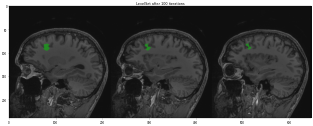

In [10]:
zslice_offset = 4
t = "LevelSet after " + str(lsFilter.GetNumberOfIterations()) + " iterations"
myshow3d(
    sitk.LabelOverlay(img_T1_255, ls > 0),
    zslices=range(idx[2] - zslice_offset, idx[2] + zslice_offset + 1, zslice_offset),
    dpi=20,
    title=t,
)

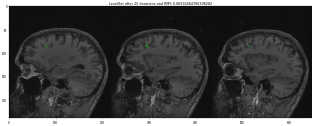

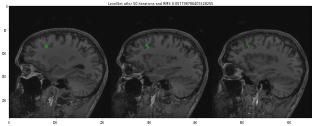

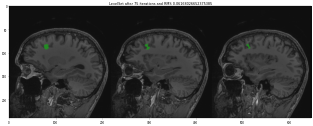

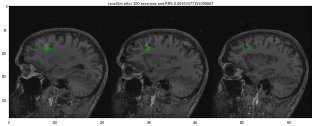

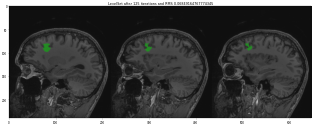

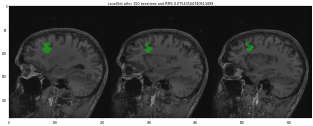

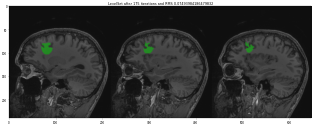

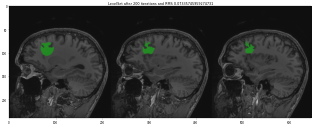

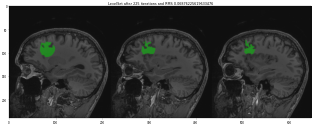

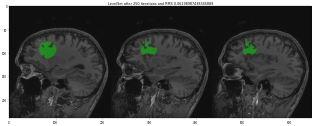

In [11]:
lsFilter.SetNumberOfIterations(25)
img_T1f = sitk.Cast(img_T1, sitk.sitkFloat32)
ls = init_ls
niter = 0
for i in range(0, 10):
    ls = lsFilter.Execute(ls, img_T1f)
    niter += lsFilter.GetNumberOfIterations()
    t = (
        "LevelSet after "
        + str(niter)
        + " iterations and RMS "
        + str(lsFilter.GetRMSChange())
    )
    fig = myshow3d(
        sitk.LabelOverlay(img_T1_255, ls > 0),
        zslices=range(
            idx[2] - zslice_offset, idx[2] + zslice_offset + 1, zslice_offset
        ),
        dpi=20,
        title=t,
    )